<a href="https://colab.research.google.com/github/sedol1339/voice_score/blob/main/process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone -q https://github.com/sedol1339/voice_score
%cd voice_score
%run utils2.ipynb
data.sample(5)

/content/voice_score


,subset,system,utterance,file,file_exists,score_mean,score_std,n_votes,votes1,votes2,votes3,votes4,votes5,fold
4723,train,sysc84fa,uttd39ad61,sysc84fa-uttd39ad61.wav,False,3.750,1.1650,8,0,2,0,4,2,3
4151,train,sysb084d,utt078e24a,sysb084d-utt078e24a.wav,True,2.750,0.7071,8,1,0,7,0,0,3
3929,train,sysa1387,utt6432c52,sysa1387-utt6432c52.wav,False,4.250,0.8864,8,0,0,2,2,4,3
936,train,sys049d2,utt93e121b,sys049d2-utt93e121b.wav,False,4.375,0.7440,8,0,0,1,3,4,0
4668,train,sysc2927,uttb2d1e73,sysc2927-uttb2d1e73.wav,True,2.125,0.6409,8,1,5,2,0,0,3


In [2]:
import time

device = 'cuda'
wave2vec2_model = get_wave2vec2_model(device).eval()

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

## Источники данных

In [17]:
data_sources = {
    f'wave2vec2.{layer}': lambda file: file_to_wave2vec2_outputs(wave2vec2_model, file, device, output_layers=[layer])[0]
    for layer in [
          'feature_extractor.conv_layers.3',
          'feature_extractor.conv_layers.5',
          'feature_extractor.conv_layers.6',
          'transformer.layers.0',
          'transformer.layers.2',
          'transformer.layers.4',
          'transformer.layers.6',
          'transformer.layers.8',
          'transformer.layers.10',
    ]
}

data_sources['wave2vec2.mix1'] = lambda file: np.concatenate(file_to_wave2vec2_outputs(wave2vec2_model, file, device,
                          output_layers=['feature_extractor.conv_layers.6', 'transformer.layers.6']), axis=1)
data_sources['wave2vec2.mix2'] = lambda file: np.concatenate(file_to_wave2vec2_outputs(wave2vec2_model, file, device,
                          output_layers=['feature_extractor.conv_layers.6', 'transformer.layers.6', 'transformer.layers.10']), axis=1)
data_sources['wave2vec2.mix3'] = lambda file: np.concatenate(file_to_wave2vec2_outputs(wave2vec2_model, file, device,
                          output_layers=['transformer.layers.6', 'transformer.layers.10']), axis=1)

## Источники данных: проверка времени работы

In [18]:
test_files = ['sys02a43-uttd08a661.wav', 'sys05205-utt61fd125.wav', 'sys19236-uttc22d6bc.wav',
              'sys35c79-utt834bb2b.wav', 'sys4017d-uttb8d822a.wav'] #all files are around 3.4 sec length - mean length of all dataset
for name, func in data_sources.items():
  start_time = time.time()
  for file in test_files:
    result = func(file)
    assert result.ndim == 2
  time_per_file = (time.time() - start_time) / len(test_files)
  print(f'[{time_per_file:g} sec/file, {time_per_file*2641:g} sec/dataset] {name}')

[0.01655 sec/file, 43.7086 sec/dataset] wave2vec2.feature_extractor.conv_layers.3
[0.016026 sec/file, 42.3247 sec/dataset] wave2vec2.feature_extractor.conv_layers.5
[0.0159383 sec/file, 42.0931 sec/dataset] wave2vec2.feature_extractor.conv_layers.6
[0.0150765 sec/file, 39.817 sec/dataset] wave2vec2.transformer.layers.0
[0.0147387 sec/file, 38.9248 sec/dataset] wave2vec2.transformer.layers.2
[0.0147783 sec/file, 39.0296 sec/dataset] wave2vec2.transformer.layers.4
[0.015116 sec/file, 39.9213 sec/dataset] wave2vec2.transformer.layers.6
[0.014628 sec/file, 38.6326 sec/dataset] wave2vec2.transformer.layers.8
[0.0146067 sec/file, 38.5762 sec/dataset] wave2vec2.transformer.layers.10
[0.0153188 sec/file, 40.457 sec/dataset] wave2vec2.mix1
[0.0154502 sec/file, 40.804 sec/dataset] wave2vec2.mix2
[0.0150635 sec/file, 39.7826 sec/dataset] wave2vec2.mix3


## Способы обработки данных

In [ ]:
!pip install -q tensorflow_addons

In [14]:
from tensorflow.keras import layers
import tensorflow_addons as tfa

data_processing = {
    'none': lambda x: x
}

random_projection_layers = {}
def random_projection(x):
  n_features = x.shape[1]
  if not n_features in random_projection_layers:
    random_projection_layers[n_features] = layers.Dense(8192, 'tanh')
    random_projection_layers[n_features].build(input_shape=(None, n_features))
  layer = random_projection_layers[n_features]
  return layer(x).numpy()

data_processing['random_projection'] = random_projection

random_rnn_layers = {}
def random_rnn(x):
  n_features = x.shape[1]
  if not n_features in random_rnn_layers:
    random_rnn_layers[n_features] = layers.GRU(512, 'tanh', return_sequences=True, time_major=True)
    random_rnn_layers[n_features].build(input_shape=(None, None, n_features))
  layer = random_rnn_layers[n_features]
  inputs = x[:, None, :] #(timesteps, batch, feature)
  outputs = layer(inputs)[:, 0, :].numpy() #(timesteps, feature)
  return outputs

data_processing['random_rnn'] = random_rnn

random_esn_layers = {}
def random_esn(x):
  n_features = x.shape[1]
  if not n_features in random_esn_layers:
    random_esn_layers[n_features] = tfa.layers.ESN(512, return_sequences=True)
    random_esn_layers[n_features].build(input_shape=(None, None, n_features))
  layer = random_esn_layers[n_features]
  inputs = x[None, :, :] #(batch, timesteps, feature)
  outputs = layer(inputs)[0, :, :].numpy() #(timesteps, feature)
  return outputs

data_processing['random_esn'] = random_esn

## Способы обработки данных: проверка времени работы

In [16]:
for name, func in data_processing.items():
  assert func(np.zeros((10, 768))).ndim == 2
  start_time = time.time()
  for file in test_files:
    result = func(np.zeros((170, 768))) #170 frames (3.4 sec, 50 Hz), 768 features
    assert result.ndim == 2
  time_per_file = (time.time() - start_time) / len(test_files)
  print(f'[{time_per_file:g} sec/file, {time_per_file*2641:g} sec/dataset] {name}')

[0.000280809 sec/file, 0.741618 sec/dataset] none
[0.0056963 sec/file, 15.0439 sec/dataset] random_projection
[0.00705595 sec/file, 18.6348 sec/dataset] random_rnn
[0.148099 sec/file, 391.13 sec/dataset] random_esn


## Способы избавления от временной оси

In [10]:
data_reduction = {
    'last': lambda x: x[-1],
    'mean': lambda x: x.mean(axis=0),
    'mean_std': lambda x: np.concatenate([x.mean(axis=0), x.std(axis=0)]),
    'max': lambda x: x.max(axis=0),
}

In [22]:
reduction_ops_for_processing = {
    'none': {'mean', 'mean_std', 'max'},
    'random_projection': {'mean', 'mean_std', 'max'},
    'random_rnn': {'last', 'mean', 'mean_std', 'max'},
    'random_esn': {'last', 'mean', 'mean_std', 'max'},
}

cannot_pregenerate = ['wave2vec2.feature_extractor.conv_layers.3']

## Создание/обновление датасетов

In [ ]:
!gcloud auth login

In [ ]:
saved_datasets = !gsutil ls gs://oleg-zyablov/misc/VoiceMOS/datasets
saved_datasets = set([x.split('/')[-1] for x in saved_datasets[1:]])

def get_filename(src_name, proc_name, reduction_name):
  return f'{src_name}__{proc_name}__{reduction_name}.npz'

# filenames = set()
# for src_name, src_func in data_sources.items():
#   for proc_name, proc_func in data_processing.items():
#     for reduction_name, reduction_func in data_reduction.items():
#       filenames.add(get_filename(src_name, proc_name, reduction_name))
# datasets_to_save = filenames.difference([x for x in saved_datasets])
# print(f'{len(saved_datasets)} datasets already saved, {len(datasets_to_save)} to save')

In [28]:
train_and_val_files = data[data.subset.isin(['train', 'test']) & data.file_exists].file

for source_name, source_fn in tqdm(data_sources.items()):
  if not source_name in cannot_pregenerate:
    pregenerated = {}
    for file in tqdm(train_and_val_files, leave=False, desc=f'pregenerating source {source_name}'):
      pregenerated[file] = source_fn(file)
  else:
    pregenerated = None
  for proc_name, proc_fn in tqdm(data_processing.items(), leave=False, desc=f'source = {source_name}'):
    reduction_names = reduction_ops_for_processing[proc_name]
    results = {reduction_name: [] for reduction_name in reduction_names}
    for file in tqdm(train_and_val_files, leave=False, desc=f'proc = {proc_name}'):
      x = pregenerated[file] if not source_name in cannot_pregenerate else source_fn(file)
      x = proc_fn(x)
      for reduction_name in reduction_names:
        reduction_op = data_reduction[reduction_name]
        result = reduction_op(x)
        results[reduction_name].append(result)
    for reduction_name in reduction_names:
      filename = get_filename(source_name, proc_name, reduction_name)
      array = np.array(results[reduction_name])
      assert len(array) == len(train_and_val_files)
      np.savez_compressed(filename, array)
      !gsutil -q cp {filename} gs://oleg-zyablov/misc/VoiceMOS/datasets/{filename}
      !rm {filename}

  0%|          | 0/12 [00:00<?, ?it/s]

source = wave2vec2.feature_extractor.conv_layers.3:   0%|          | 0/4 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2254 [00:00<?, ?it/s]

pregenerating source wave2vec2.feature_extractor.conv_layers.5:   0%|          | 0/2254 [00:00<?, ?it/s]

source = wave2vec2.feature_extractor.conv_layers.5:   0%|          | 0/4 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2254 [00:00<?, ?it/s]

pregenerating source wave2vec2.feature_extractor.conv_layers.6:   0%|          | 0/2254 [00:00<?, ?it/s]

source = wave2vec2.feature_extractor.conv_layers.6:   0%|          | 0/4 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2254 [00:00<?, ?it/s]

pregenerating source wave2vec2.transformer.layers.0:   0%|          | 0/2254 [00:00<?, ?it/s]

source = wave2vec2.transformer.layers.0:   0%|          | 0/4 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2254 [00:00<?, ?it/s]

pregenerating source wave2vec2.transformer.layers.2:   0%|          | 0/2254 [00:00<?, ?it/s]

source = wave2vec2.transformer.layers.2:   0%|          | 0/4 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2254 [00:00<?, ?it/s]

pregenerating source wave2vec2.transformer.layers.4:   0%|          | 0/2254 [00:00<?, ?it/s]

source = wave2vec2.transformer.layers.4:   0%|          | 0/4 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2254 [00:00<?, ?it/s]

pregenerating source wave2vec2.transformer.layers.6:   0%|          | 0/2254 [00:00<?, ?it/s]

source = wave2vec2.transformer.layers.6:   0%|          | 0/4 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2254 [00:00<?, ?it/s]

pregenerating source wave2vec2.transformer.layers.8:   0%|          | 0/2254 [00:00<?, ?it/s]

source = wave2vec2.transformer.layers.8:   0%|          | 0/4 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2254 [00:00<?, ?it/s]

pregenerating source wave2vec2.transformer.layers.10:   0%|          | 0/2254 [00:00<?, ?it/s]

source = wave2vec2.transformer.layers.10:   0%|          | 0/4 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2254 [00:00<?, ?it/s]

pregenerating source wave2vec2.mix1:   0%|          | 0/2254 [00:00<?, ?it/s]

source = wave2vec2.mix1:   0%|          | 0/4 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2254 [00:00<?, ?it/s]

pregenerating source wave2vec2.mix2:   0%|          | 0/2254 [00:00<?, ?it/s]

source = wave2vec2.mix2:   0%|          | 0/4 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2254 [00:00<?, ?it/s]

pregenerating source wave2vec2.mix3:   0%|          | 0/2254 [00:00<?, ?it/s]

source = wave2vec2.mix3:   0%|          | 0/4 [00:00<?, ?it/s]

proc = none:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_projection:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_rnn:   0%|          | 0/2254 [00:00<?, ?it/s]

proc = random_esn:   0%|          | 0/2254 [00:00<?, ?it/s]

## Тест загрузки данных

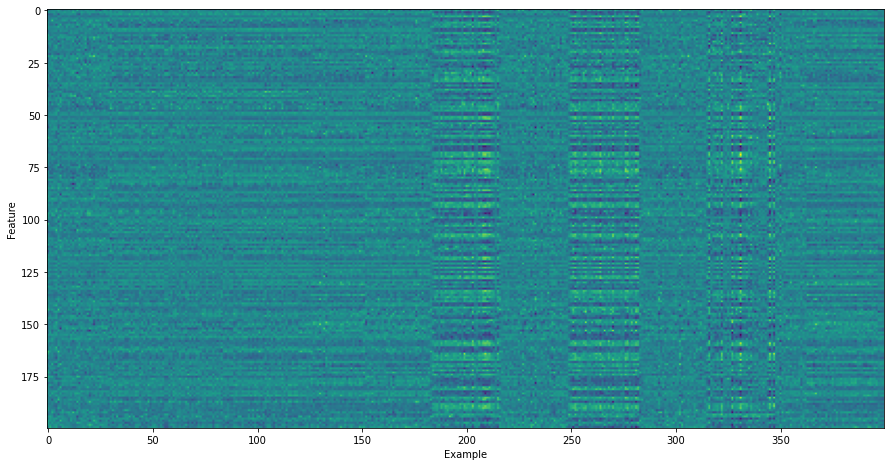

In [ ]:
filename = 'wave2vec2.feature_extractor.conv_layers.5__none__mean.npz'
!wget -q https://storage.googleapis.com/oleg-zyablov/misc/VoiceMOS/datasets/{filename}
arr = np.load(filename)['arr_0']

from sklearn.preprocessing import StandardScaler

plt.figure(figsize=(15, 15))
plt.imshow(StandardScaler().fit_transform(arr)[:400, :200].T)
plt.xlabel('Example')
plt.ylabel('Feature')
plt.show()